# TLC Trip Record Data

Yellow and green taxi trip records include fields capturing pickup and drop-off dates/times, pickup and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). The trip data was not created by the TLC, and TLC makes no representations as to the accuracy of these data.

For-Hire Vehicle (“FHV”) trip records include fields capturing the dispatching base license number and the pickup date, time, and taxi zone location ID (shape file below).These records are generated from the FHV Trip Record submissions made by bases, so we cannot guarantee or confirm their accuracy or completeness. The TLC performs routine reviews of the records and takes enforcement actions when necessary to ensure, to the extent possible, complete and accurate information. Since 2019 high volume trip records (HVFHV) are reported in a separate (and more detailed) dataset.

For 2025 data onwards, a cbd_congestion_fee column has been added to the Yellow, Green, and High Volume FHV datasets to reflect new congestion pricing charges.

## Librerías

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Lectura de los dataset

In [ ]:
yellow = pd.read_parquet('yellow_tripdata_2025-01.parquet')
green = pd.read_parquet('green_tripdata_2025-01.parquet')
hvfhv = pd.read_parquet('fhvhv_tripdata_2025-01.parquet')

## Unificación de columnas

In [ ]:
yellow = yellow.rename(columns={
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime',
    'trip_distance': 'trip_miles',
    'tolls_amount': 'tolls',
    'tip_amount': 'tips',
    'total_amount': 'driver_pay'
})

green = green.rename(columns={
    'lpep_pickup_datetime': 'pickup_datetime',
    'lpep_dropoff_datetime': 'dropoff_datetime',
    'trip_distance': 'trip_miles',
    'tolls_amount': 'tolls',
    'tip_amount': 'tips',
    'total_amount': 'driver_pay'
})

## Concatenación de dfs

In [ ]:
cols_comunes = [
    'pickup_datetime', 'dropoff_datetime', 'trip_miles',
    'PULocationID', 'DOLocationID',
    'fare_amount', 'base_passenger_fare',
    'tolls', 'tips', 'driver_pay',
    'congestion_surcharge', 'cbd_congestion_fee', 'airport_fee'
]

yellow = yellow[[c for c in cols_comunes if c in yellow.columns]]
green  = green[[c for c in cols_comunes if c in green.columns]]
hvfhv  = hvfhv[[c for c in cols_comunes if c in hvfhv.columns]]

df_final = pd.concat([yellow, green, hvfhv], ignore_index=True)

In [ ]:
print(df_final.info())
print(df_final.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23929218 entries, 0 to 23929217
Data columns (total 13 columns):
 #   Column                Dtype         
---  ------                -----         
 0   pickup_datetime       datetime64[ns]
 1   dropoff_datetime      datetime64[ns]
 2   trip_miles            float64       
 3   PULocationID          int32         
 4   DOLocationID          int32         
 5   fare_amount           float64       
 6   tolls                 float64       
 7   tips                  float64       
 8   driver_pay            float64       
 9   congestion_surcharge  float64       
 10  cbd_congestion_fee    float64       
 11  base_passenger_fare   float64       
 12  airport_fee           float64       
dtypes: datetime64[ns](2), float64(9), int32(2)
memory usage: 2.1 GB
None
      pickup_datetime    dropoff_datetime  trip_miles  PULocationID  \
0 2025-01-01 00:18:38 2025-01-01 00:26:59        1.60           229   
1 2025-01-01 00:32:40 2025-01-01 00:35:

## EDA

### Tipificación

In [ ]:
df = df_final.copy()

for col in ['pickup_datetime', 'dropoff_datetime']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

### Características de tiempo y duración

In [ ]:
df['duration_min'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60.0
df['pickup_hour']  = df['pickup_datetime'].dt.hour
df['pickup_wday']  = df['pickup_datetime'].dt.weekday   
df['is_weekend']   = (df['pickup_wday'] >= 5).astype('int8')

### Unificación de tarifa base

In [ ]:
df['fare_equiv']  = np.where(df['fare_amount'].notna(), df['fare_amount'], df['base_passenger_fare'])
df['total_equiv'] = df['driver_pay']  

### Validaciones Básicas

In [ ]:
# 4) Reglas lógicas básicas
# Fechas válidas
mask_time_ok = (df['pickup_datetime'].notna() & df['dropoff_datetime'].notna() &
                (df['dropoff_datetime'] >= df['pickup_datetime']))
df = df[mask_time_ok].copy()

# Duración y distancia razonables
df = df[(df['duration_min'] > 0)].copy()
df = df[(df['trip_miles'] > 0)].copy()

# Velocidad promedio
df['avg_mph'] = df['trip_miles'] / (df['duration_min'] / 60.0)
df = df[(df['avg_mph'] >= 0)].copy()

# 5) No negatividad e imputaciones benignas
for col in ['tolls', 'tips', 'congestion_surcharge', 'cbd_congestion_fee', 'airport_fee']:
    if col in df.columns:
        df[col] = df[col].fillna(0)
        df = df[df[col] >= 0]
        
#TODO:  Decidir qué hacer con fare_equiv y total_equiv ya que son las variables más importantes a la hora de modelar regresión
# for col in ['fare_equiv', 'total_equiv']:
#     if col in df.columns:
#         # Si faltan, decide: imputar 0 (si "no aplica") o eliminar:
#         df[col] = df[col].fillna(0)
#         df = df[df[col] >= 0]

### Duplicados

In [ ]:
df = df.drop_duplicates()

### Manejo de Outliers

In [ ]:
# Decidir si esta regla es adecuada para el análisis, alternativa pordría ser con IQR
def winsorize_series(s: pd.Series, lower=0.005, upper=0.995):
    lo, hi = s.quantile([lower, upper])
    return s.clip(lower=lo, upper=hi)

winsor_cols = ['trip_miles', 'duration_min', 'avg_mph',
            'fare_equiv', 'tolls', 'tips', 'total_equiv']

for c in winsor_cols:
    if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
        df[c] = winsorize_series(df[c], 0.005, 0.995)

### Casteo Final

In [ ]:
int_cols = ['PULocationID', 'DOLocationID', 'pickup_hour', 'pickup_wday', 'is_weekend']
for c in int_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')

float_cols = ['trip_miles', 'duration_min', 'avg_mph',
            'fare_equiv', 'tolls', 'tips', 'total_equiv',
            'congestion_surcharge', 'cbd_congestion_fee', 'airport_fee']
for c in float_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('float64')

cols_model = [
    'pickup_datetime', 'dropoff_datetime',
    'PULocationID', 'DOLocationID',
    'trip_miles', 'duration_min', 'avg_mph',
    'pickup_hour', 'pickup_wday', 'is_weekend',
    'fare_equiv', 'tolls', 'tips', 'total_equiv',
    'congestion_surcharge', 'cbd_congestion_fee', 'airport_fee'
]
cols_model = [c for c in cols_model if c in df.columns]

df_model = df[cols_model].reset_index(drop=True)

In [ ]:
print(df_model.info())
df_model.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23784573 entries, 0 to 23784572
Data columns (total 17 columns):
 #   Column                Dtype         
---  ------                -----         
 0   pickup_datetime       datetime64[ns]
 1   dropoff_datetime      datetime64[ns]
 2   PULocationID          Int64         
 3   DOLocationID          Int64         
 4   trip_miles            float64       
 5   duration_min          float64       
 6   avg_mph               float64       
 7   pickup_hour           Int64         
 8   pickup_wday           Int64         
 9   is_weekend            Int64         
 10  fare_equiv            float64       
 11  tolls                 float64       
 12  tips                  float64       
 13  total_equiv           float64       
 14  congestion_surcharge  float64       
 15  cbd_congestion_fee    float64       
 16  airport_fee           float64       
dtypes: Int64(5), datetime64[ns](2), float64(10)
memory usage: 3.1 GB
None


,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,duration_min,avg_mph,pickup_hour,pickup_wday,is_weekend,fare_equiv,tolls,tips,total_equiv,congestion_surcharge,cbd_congestion_fee,airport_fee
0,2025-01-01 00:18:38,2025-01-01 00:26:59,229,237,1.60,8.350000,11.497006,0,2,0,10.0,0.0,3.00,18.00,2.5,0.0,0.0
1,2025-01-01 00:32:40,2025-01-01 00:35:13,236,237,0.50,2.550000,11.764706,0,2,0,5.1,0.0,2.02,12.12,2.5,0.0,0.0
2,2025-01-01 00:44:04,2025-01-01 00:46:01,141,141,0.60,2.383333,18.461538,0,2,0,5.1,0.0,2.00,12.10,2.5,0.0,0.0
3,2025-01-01 00:14:27,2025-01-01 00:20:01,244,244,0.52,5.566667,5.604790,0,2,0,7.2,0.0,0.00,9.70,0.0,0.0,0.0
4,2025-01-01 00:21:34,2025-01-01 00:25:06,244,116,0.66,3.533333,11.207547,0,2,0,5.8,0.0,0.00,8.30,0.0,0.0,0.0


### Distribuciones

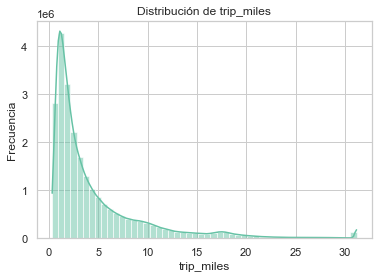

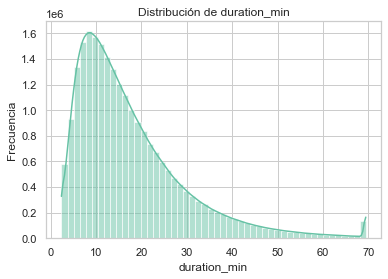

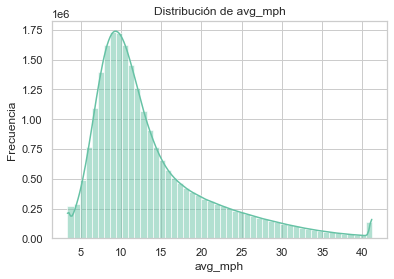

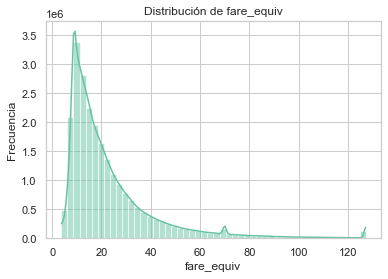

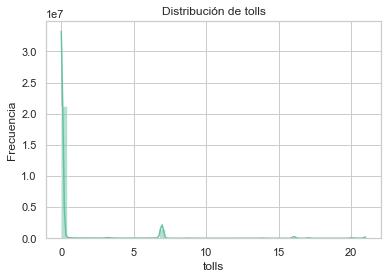

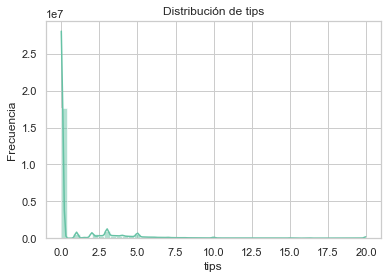

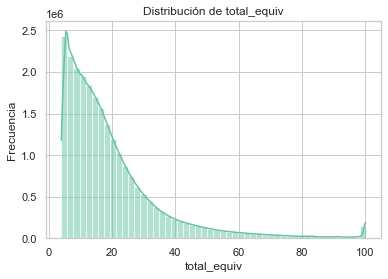

In [ ]:
sns.set_theme(style='whitegrid', palette='Set2')
plt.rcParams['figure.figsize'] = (10, 5)

num_cols = ['trip_miles', 'duration_min', 'avg_mph',
            'fare_equiv', 'tolls', 'tips', 'total_equiv']

for col in num_cols:
    if col in df_model.columns:
        plt.figure()
        sns.histplot(df_model[col], kde=True, bins=50)
        plt.title(f'Distribución de {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.show()

### Boxplots

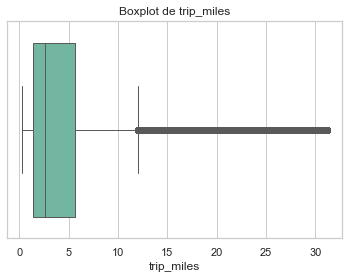

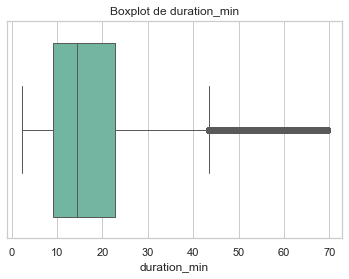

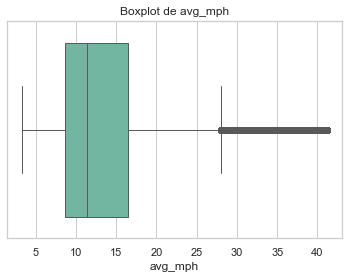

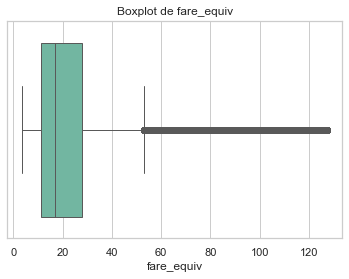

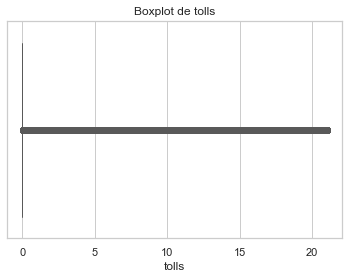

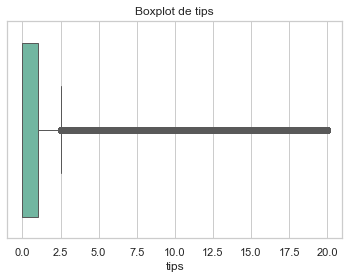

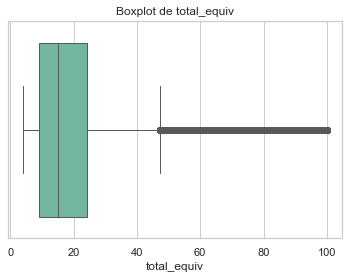

In [12]:
for col in num_cols:
    if col in df_model.columns:
        plt.figure()
        sns.boxplot(x=df_model[col])
        plt.title(f'Boxplot de {col}')
        plt.show()

### Correlación

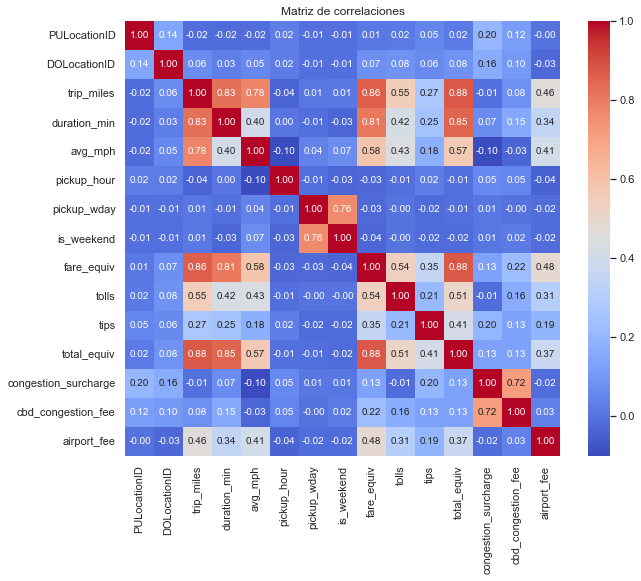

In [13]:
numeric_df = df_model.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de correlaciones")
plt.show()

In [ ]:
if 'total_equiv' in numeric_df.columns:
    corr_target = corr['total_equiv'].sort_values(ascending=False)
    print("📊 Correlaciones con total_equiv:")
    print(corr_target)

📊 Correlaciones con total_equiv:
total_equiv             1.000000
trip_miles              0.877227
fare_equiv              0.876504
duration_min            0.849587
avg_mph                 0.569454
tolls                   0.506843
tips                    0.414812
airport_fee             0.368220
cbd_congestion_fee      0.131305
congestion_surcharge    0.127278
DOLocationID            0.083692
PULocationID            0.017638
pickup_hour            -0.008678
pickup_wday            -0.013701
is_weekend             -0.023162
Name: total_equiv, dtype: float64


### Estacionalidad

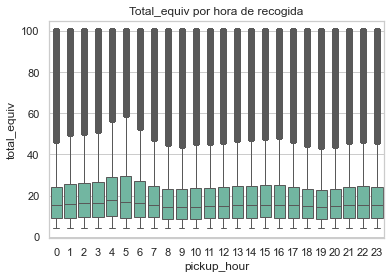

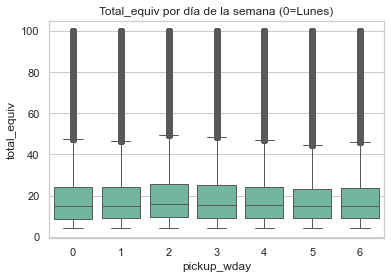

In [15]:
if {'pickup_hour', 'pickup_wday'}.issubset(df_model.columns):
    plt.figure()
    sns.boxplot(x='pickup_hour', y='total_equiv', data=df_model)
    plt.title('Total_equiv por hora de recogida')
    plt.show()

    plt.figure()
    sns.boxplot(x='pickup_wday', y='total_equiv', data=df_model)
    plt.title('Total_equiv por día de la semana (0=Lunes)')
    plt.show()

### Patrones Espaciales

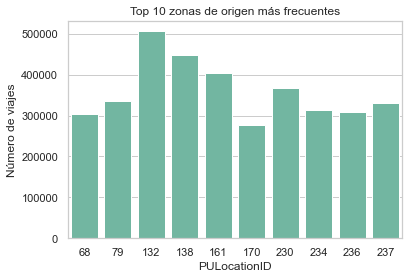

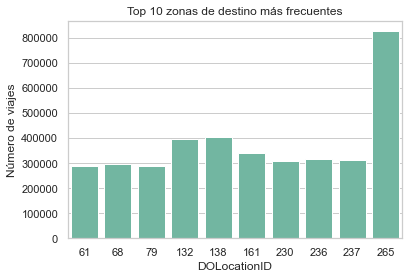

In [16]:
if {'PULocationID', 'DOLocationID'}.issubset(df_model.columns):
    top_pu = df_model['PULocationID'].value_counts().head(10)
    top_do = df_model['DOLocationID'].value_counts().head(10)

    plt.figure()
    sns.barplot(x=top_pu.index, y=top_pu.values)
    plt.title("Top 10 zonas de origen más frecuentes")
    plt.xlabel("PULocationID")
    plt.ylabel("Número de viajes")
    plt.show()

    plt.figure()
    sns.barplot(x=top_do.index, y=top_do.values)
    plt.title("Top 10 zonas de destino más frecuentes")
    plt.xlabel("DOLocationID")
    plt.ylabel("Número de viajes")
    plt.show()